# Fashion (Kernel)

In [1]:
from sklearn.datasets import fetch_openml
fashion_mnist = fetch_openml(data_id=40996)

In [2]:
fashion_mnist['data'].shape

(70000, 784)

In [3]:
c = '0  T-shirt/top  \n1  Trouser  \n2  Pullover  \n3  Dress  \n4  Coat  \n5  Sandal  \n6  Shirt  \n7  Sneaker  \n8  Bag  \n9  Ankle boot'

fashion_label_translation = {
    int(k): v for k, v in [
        item.split(maxsplit=1) for item in c.split('\n')
    ]
}

fashion_label_translation

def translate_y(y):
    return pd.Series(y).apply(
        lambda y: fashion_label_translation[int(y)]
    ).values

In [20]:
from matplotlib.colors import ListedColormap

img_w = np.sqrt(fashion_mnist['data'].shape[1]).astype(int)

def display_fashion(img, target, ax):
    
    if len(img.shape) == 1:
        img = img.reshape((img_w, img_w))
    
    ax.imshow(img, cmap='Greys')
    ax.set_title(f'{target}')
    ax.grid(False)

In [136]:
from sklearn.model_selection import train_test_split

classes_to_select = None # ('5','7')

if classes_to_select:
    x = pd.DataFrame(fashion_mnist['data'])
    y = pd.Series(fashion_mnist['target'])

    x_train, x_test, y_train, y_test = train_test_split(
        x[y.isin(classes_to_select)].values, 
        y[y.isin(classes_to_select)].values, 
        test_size=0.2
    ) 
else:
    x, y = fashion_mnist['data'], fashion_mnist['target']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [137]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [138]:
y_train_translated = translate_y(y_train)
y_test_translated = translate_y(y_test)

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
# clf = LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=500)
clf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, early_stopping=False, verbose=0)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

clf.fit(x_train_scaled, y_train)

y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)


from sklearn.metrics import accuracy_score

print(
    'Digits test accuracy score: {:.1%} [train score: {:.1%}]'.format(
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_train, y_train_pred)
    )
    
)

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Digits test accuracy score: 83.1% [train score: 84.6%]


## Kernel

In [150]:
from scipy import ndimage

k_sharpen = [[0,-1,0], [-1,5,-1], [0,-1,0]]
k_box_blur = [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]
k_box_blur2 = [[1/16,1/16,1/16,1/16],[1/16,1/4,1/4,1/16], [1/16,1/4,1/4,1/16], [1/16,1/16,1/16,1/16]]
k_smooth = [[0.1,0.1,0.1],[0.1,0.2,0.1],[0.1,0.1,0.1]]
k_gaussian_blur = [[1,2,1], [2,4,2], [1,2,1]]
k_edge = [[1,1,1],[1,-8,1],[1,1,1]]
k_hline = [[-1,-1,-1],[2,2,2],[-1,-1,-1]]
k_vline = [[-1,2,-1],[-1,2,-1],[-1,2,-1]]

k = k_edge

side = int(np.sqrt(x_train.shape[1]))

x_train_conv = ndimage.convolve(x_train.reshape((x_train.shape[0], side, side)), [k], mode='reflect', cval=0.0) 
x_test_conv = ndimage.convolve(x_test.reshape((x_test.shape[0], side, side)), [k], mode='reflect', cval=0.0)

x_train_conv = x_train_conv.reshape(x_train_conv.shape[0], x_train_conv.shape[1]*x_train_conv.shape[2]) 
x_test_conv = x_test_conv.reshape(x_test_conv.shape[0], x_test_conv.shape[1]*x_test_conv.shape[2]) 


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((x_train.min(), x_train.max()))

x_train_conv = scaler.fit_transform(x_train_conv)
x_test_conv = scaler.transform(x_test_conv)

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


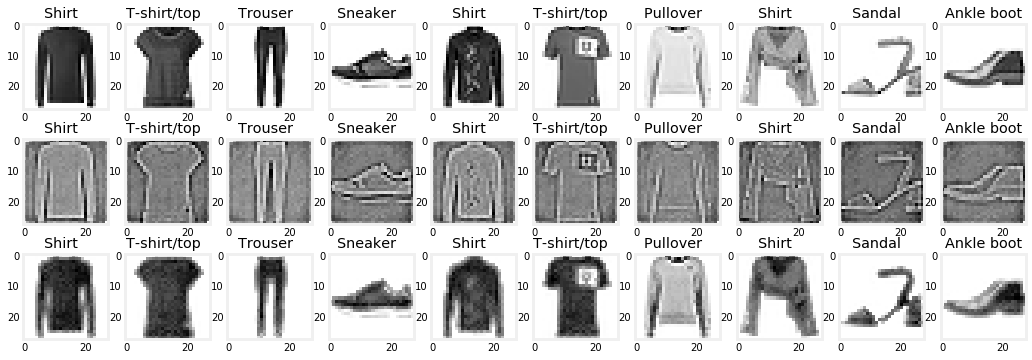

In [152]:
fig, axs = plt.subplots(3, 10, figsize=(16, 6))

import random 

for i in range(10):
    rand = random.choice(range(x_train.shape[0]))
    display_fashion(x_train[rand], y_train_translated[rand], axs[0][i])
    display_fashion(x_train_conv[rand], y_train_translated[rand], axs[1][i])
    display_fashion(x_train[rand] * x_train_conv[rand], y_train_translated[rand], axs[2][i])

fig.show()

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=500)
clf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, early_stopping=False, verbose=0)

x_train_scaled = scaler.fit_transform(x_train_conv + x_train)
x_test_scaled = scaler.transform(x_test_conv * x_test)

clf.fit(x_train_scaled, y_train)

y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)


from sklearn.metrics import accuracy_score

print(
    'Digits test accuracy score: {:.1%} [train score: {:.1%}]'.format(
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_train, y_train_pred)
    )
    
)

Digits test accuracy score: 64.5% [train score: 83.6%]


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


NameError: name 'x_train' is not defined